# get_color_hex_incl_manual_changes
The purpose of this notebook is to illustrate how to obtain the color hex strings for segment ids in Neuroglancer for a segmentation layer. In this notebook, I name the segmentation layer "atlas" but you can change this string to whatever you want. This notebook handles cases where the colors of individual segments may or may not have been manually changed by the user in Neuroglancer. This feature is merged with the Google fork of the Neuroglancer client (https://github.com/google/neuroglancer/pull/224) and will be included in the next release of neuroglancer with pip (as of 6/8/2020). 

In [11]:
import neuroglancer
import math, sys
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Start the viewer and load in some data. You must have a segmentation layer launched at port 1338 on your machine
# via cloudvolume, for example. See the "Getting_started_with_neuroglancer.ipynb" for instructions if needed

# Use the BRAIN CoGS Neuroglancer client
neuroglancer.set_static_content_source(url='https://nglancer.pni.princeton.edu')
# Start the viewer
viewer = neuroglancer.Viewer()
# Load in the atlas as a SegmentationLayer. Any segmentation layer will do in this example
with viewer.txn() as s:
    s.layers['atlas'] = neuroglancer.SegmentationLayer(source='precomputed://http://localhost:1338'
    )
print(viewer)
# Link generated below brings you to the Neuroglancer browser interface with your layer loaded in

http://127.0.0.1:45891/v/b416a4f18d5cb0b5ffee375f1c16c2f4e72a321f/


In [4]:
# Define the functions for finding the color hex strings given the color seed that Neuroglancer sets
# and a segment id. These functions should not be modified.
def hash_function(state,value):
    """ Python implementation of hashCombine() function
    in src/neuroglancer/gpu_hash/hash_function.ts,
    a modified murmur hcolorash
    """
    k1 = 0xcc9e2d51
    k2 = 0x1b873593
    state = state & 0xffffffff
    value = (value * k1) & 0xffffffff
    value = ((value << 15) | value >> 17) & 0xffffffff
    value = (value * k2) & 0xffffffff
    state = (state ^ value) & 0xffffffff
    state = (( state << 13) | state >> 19) & 0xffffffff
    state = (( state * 5) + 0xe6546b64) & 0xffffffff
    return state

def hsv_to_rgb(h,s,v):
    """ Convert H,S,V values to RGB values.
    Python implementation of hsvToRgb in src/neuroglancer/util/colorspace.ts """
    h*=6
    hue_index = math.floor(h)
    remainder = h - hue_index
    val1 = v*(1-s)
    val2 = v*(1-(s*remainder))
    val3 = v*(1-(s*(1-remainder)))
    hue_remainder = hue_index % 6
    if hue_remainder == 0:
        return (v,val3,val1)
    elif hue_remainder == 1:
        return (val2,v,val1)
    elif hue_remainder == 2:
        return (val1,v,val3)
    elif hue_remainder == 3:
        return (val1,val2,v)
    elif hue_remainder == 4:
        return (val3,val1,v)
    elif hue_remainder == 5: 
        return (v,val1,val2)   

def pack_color(rgb_vec):
    """ Returns an integer formed
    by concatenating the channels of the input color vector.
    Python implementation of packColor in src/neuroglancer/util/color.ts
    """
    result = 0
    for i in range(len(rgb_vec)):
        result = ((result << 8) & 0xffffffff) + min(255,max(0,round(rgb_vec[i]*255)))
    return result

def hex_string_from_segment_id(color_seed,segment_id):
    """ Return the hex color string for a segment
    given a color seed and the segment id """
    segment_id = int(segment_id) # necessary since segment_id is 64 bit originally 
    result = hash_function(state=color_seed,value=segment_id)
    newvalue = segment_id >> 32
    result2 = hash_function(state=result,value=newvalue)
    c0 = (result2 & 0xFF) / 255.
    c1 = ((result2 >> 8) & 0xFF) / 255.;
    h = c0
    s =  0.5 + 0.5 * c1
    v = 1.0
    rgb=hsv_to_rgb(h,s,v)
    packed_color = pack_color(rgb_vec=rgb)
    hex_string = format(packed_color, 'x')
    """ Zero pad the hex string if less than 6 characeters """
    if len(hex_string) < 6:
        hex_string = '0'*(6-len(hex_string)) + hex_string
    hex_string = '#' + hex_string
    return hex_string

At this point you should select whatever segments you want the colors for in the Neuroglancer window. Get your color scheme set up that you like by recoloring ("l" key), make manual color changes, etc...

When that is all set, run the following code block to get the dictionary mapping segment id to color hex string for whatever is currently selected in the window.

Colors of your segments are:
{'10': '#51ff1c', '129': '#70ff8f', '149': '#ff6dcd', '171': '#ff7f9d', '206': '#0190ff', '310': '#75ff2a', '313': '#ff8c30', '477': '#44ffbf', '484': '#7aff9a', '560581568': '#ff3e30', '564': '#3cff93', '581': '#ffec6e', '588': '#e86cff', '59': '#79b2ff', '597': '#63ff26', '599': '#5dcfff', '607344832': '#ff0612', '707': '#71d2ff', '946': '#7dffab', '997': '#e6ff5a'}



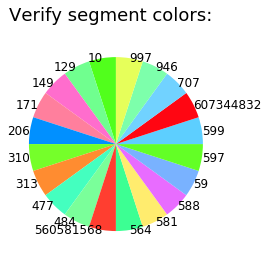

In [22]:
# Gets the list of active segments, the current color seed and any manual changes 
with viewer.txn() as s:
    seglayer = s.layers['atlas'].layer
    seg_dict = seglayer.to_json()
    try:
        color_seed = seg_dict['colorSeed']
    except:
        color_seed = 0
    try:
        active_segments=list(seg_dict['segments'])
    except:
        active_segments=[]
    try:
        manual_segment_dict = seg_dict['segmentColors']
    except:
        manual_segment_dict = {}
if active_segments == []:
    sys.exit("You do not have any active segments selected. Select some segments and try re-running this block")
    
# Fill a dictionary where
# keys will be segment id, values will be hex color string
# taking the manually set value over the original one if present
hex_str_dict = {}
for segment_id in active_segments:
    if segment_id in manual_segment_dict:
        hex_str_dict[segment_id] = manual_segment_dict[segment_id]
    else:
        hex_str_dict[segment_id] = hex_string_from_segment_id(color_seed,segment_id)
print("Colors of your segments are:")
print(hex_str_dict)
print()

sizes = [360/float(len(active_segments)) for x in active_segments]

fig1, ax1 = plt.subplots()
pie=ax1.pie(sizes,labels=hex_str_dict.keys(),labeldistance=1.0,
        textprops={'fontsize': 12}, startangle=90,colors=hex_str_dict.values())
title=fig1.suptitle('Verify segment colors:',fontsize=18)